In [1]:
# import python scripts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from scipy.stats import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
from logistic import logistic as logistic

In [2]:
# Importing data
df = pd.read_excel('EV_scenarios.xls', sheet_name="Penetration in sales")
# df.tail()

In [9]:
# Create logistic fits for all drivetrains and all scenarios
NS = len(df['Scenario'].unique())
ND = len(df['Drive_train'].unique())
# Trying logistic
t = np.arange(1950,2051)
dt_fit = np.zeros((NS, ND,len(t)))
# loop over scenarios
for s_idx in range(NS):
    s = df['Scenario'].unique()[s_idx]
    # loop over drivetrains
    for d_idx in range(ND):
        d = df['Drive_train'].unique()[d_idx]
        # logistic fit
        popt, pcov = curve_fit(logistic, df.loc[(df['Scenario']==s) & (df['Drive_train']==d), 'Year'].values, df.loc[(df['Scenario']==s) & (df['Drive_train']==d), 'Value'].values, bounds=([1950, 0., 0, 0], [2050, 1000, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
        dt_fit[s_idx,d_idx,:] = logistic(t, *popt)
# calculate plug-in hybrids via mass-balance
dt_fit[:,1,:] = np.ones((NS, len(t))) - dt_fit[:,0,:] - dt_fit[:,2,:] - dt_fit[:,3,:]
# make sure that plug-in hybrids are nonnegative
dt_fit[:,1,:] = dt_fit[:,1,:].clip(min=0)
# normalize the shares
total_share = dt_fit.sum(axis = 1)
for d_idx in range(ND):
    dt_fit[:, d_idx, :] = dt_fit[:,d_idx,:] / total_share

In [10]:
dt_fit.sum(axis = 1)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]])

In [115]:
df['Scenario'].unique()

array(['STEP', 'SD'], dtype=object)

In [116]:
df['Drive_train'].unique()

array(['BEV', 'PHEV', 'ICE', 'FCEV'], dtype=object)

In [159]:
min(dt_fit[0,1,69:])

0.0

### Plotting results

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


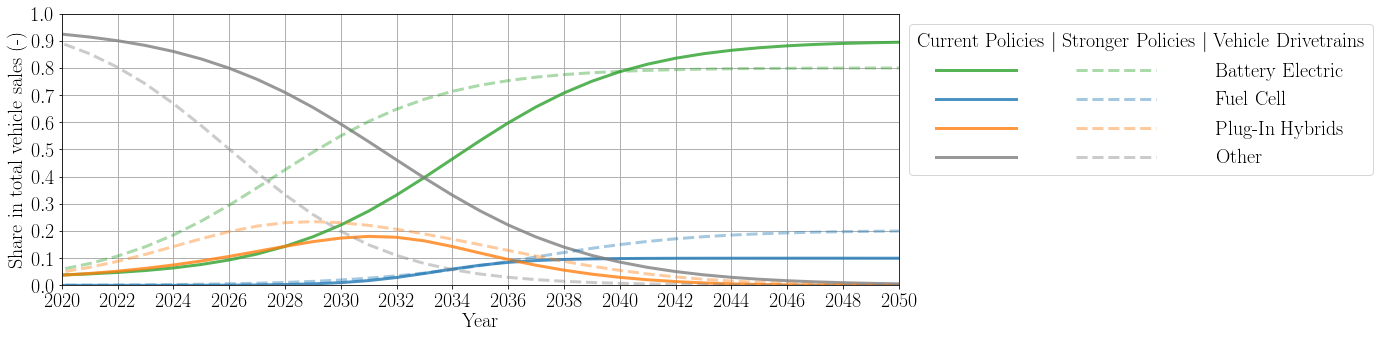

In [11]:
# layout
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
fig = plt.figure(figsize=[15, 5], facecolor ='white')
plt.rcParams.update({'font.size': 20})
transp_steps = 0.8
transp_sds = 0.4
# plotting
# Current policies
plt.plot(t[69:], dt_fit[0,0,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:green')
plt.plot(t[69:], dt_fit[0,3,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:blue')
plt.plot(t[69:], dt_fit[0,1,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:orange')
plt.plot(t[69:], dt_fit[0,2,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:gray')
# Stronger policies
plt.plot(t[69:], dt_fit[1,0,69:], label='Battery Electric', linewidth = 3, alpha = transp_sds, color = 'tab:green', linestyle = '--')
plt.plot(t[69:], dt_fit[1,3,69:], label='Fuel Cell', linewidth = 3, alpha = transp_sds, color = 'tab:blue', linestyle = '--')
plt.plot(t[69:], dt_fit[1,1,69:], label='Plug-In Hybrids', linewidth = 3, alpha = transp_sds, color = 'tab:orange', linestyle = '--')
plt.plot(t[69:], dt_fit[1,2,69:], label='Other', linewidth = 3, alpha = transp_sds, color = 'tab:gray', linestyle = '--')
# data points
# plt.plot(df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'value'].values, 'x', label='Low data')
plt.legend(loc = 'upper left', bbox_to_anchor=(1,1), title = r'Current Policies $\vert$ Stronger Policies $\vert$ Vehicle Drivetrains', ncol = 2, columnspacing = 0, handletextpad = 3, handlelength = 4)
plt.ylabel('Share in total vehicle sales (-)')
# ax.set_title('V2G ratio scenarios'.format(s))
plt.xlabel('Year')
plt.grid(linewidth = 1)
plt.xlim((2020, 2050))
plt.xticks(np.arange(2020, 2051, 2))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))
plt.savefig('vehicle_sales_drivetrain.pdf', bbox_inches = 'tight')
plt.savefig('vehicle_sales_drivetrains.png', bbox_inches = 'tight')

Text(0.5, 0, 'Year')

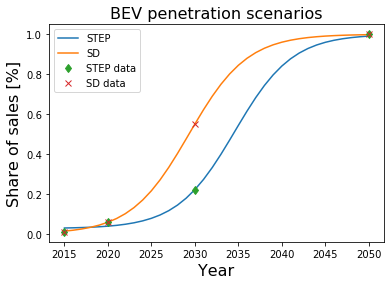

In [4]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(t[65:], dt_fit[0,1,65::], label='STEP')
ax.plot(t[65:], dt_fit[1,1,65:], label='SD')
ax.plot(df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='BEV'), 'Year'].values, df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='BEV'), 'Value'].values, 'd', label='STEP data')
ax.plot(df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='BEV'), 'Year'].values, df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='BEV'), 'Value'].values,'x',label='SD data')
ax.legend( loc='best',prop={'size':10})
ax.set_ylabel('Share of sales [%]',fontsize =16)
ax.set_title('BEV penetration scenarios'.format(s), fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [5]:
# Create logistic fits for BEVs
# Trying logistic
t = np.arange(1950,2051)
for i,s in enumerate(df['Scenario'].unique()):
        try:
            popt, pcov = curve_fit(logistic, df.loc[(df['Scenario']==s) & (df['Drive_train']=='ICE'), 'Year'].values, df.loc[(df['Scenario']==s) & (df['Drive_train']=='ICE'), 'Value'].values, bounds=([1950, 0., 0, 0], [2050, 1000, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
            dt_fit[i,0,:] = logistic(t, *popt)
        except:
            pass

Text(0.5, 0, 'Year')

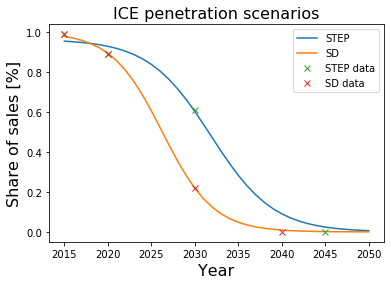

In [6]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(t[65:], dt_fit[0,0,65:], label='STEP')
ax.plot(t[65:], dt_fit[1,0,65:], label='SD')
ax.plot(df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='ICE'), 'Year'].values, df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='ICE'), 'Value'].values, 'x', label='STEP data')
ax.plot(df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='ICE'), 'Year'].values, df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='ICE'), 'Value'].values,'x',label='SD data')
ax.legend( loc='best',prop={'size':10})
ax.set_ylabel('Share of sales [%]',fontsize =16)
ax.set_title('ICE penetration scenarios'.format(s), fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [7]:
# Calculate PHEV from mass balance
dt_fit[:,2,:] = 1- dt_fit[:,1,:] - dt_fit[:,0,:]

Text(0.5, 0, 'Year')

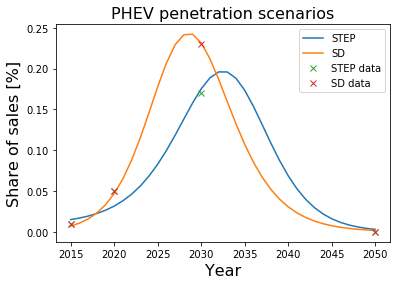

In [9]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(t[65:], dt_fit[0,2,65:], label='STEP')
ax.plot(t[65:], dt_fit[1,2,65:], label='SD')
ax.plot(df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='PHEV'), 'Year'].values, df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='PHEV'), 'Value'].values, 'x', label='STEP data')
ax.plot(df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='PHEV'), 'Year'].values, df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='PHEV'), 'Value'].values,'x',label='SD data')
ax.legend( loc='best',prop={'size':10})
ax.set_ylabel('Share of sales [%]',fontsize =16)
ax.set_title('PHEV penetration scenarios'.format(s), fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [10]:
# define results path
results_path = os.path.join(os.getcwd(), 'data', 'scenario_data')
np.save(results_path+'/EV_penetration', dt_fit, allow_pickle=True)